# Imports and Settings

This cell contains imports and settings needed to run the following cells. Run this cell before running any other cell.

In [29]:
import polars as pl
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
import  numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import random

pl.Config.set_tbl_rows(5000000)
file_path = "/Users/adi/PycharmProjects/PythonProject1/openpolicing.parquet"

# Basic Data Collection
## Warning: The output for this cell contains a lot of data.

This cell contains basic dataframes of different columns in the dataset and the count of how many times the different variations of elements in columns have occured. The output for this cell is very long, only run it if you want to see the basic data frame work done to decide which datasets to explore further.

It lists by the following columns:

1. Department
2. Race
3. Age
4. Sex
5. Type (of crime)
6. Reason for Stop

In [30]:
department_counts_df = (
    pl.scan_parquet(file_path)
    .filter(pl.col("department_name").is_not_null())
    .group_by("department_name")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

race_df = (
    pl.scan_parquet(file_path)
    .filter(pl.col("subject_race").is_not_null())
    .group_by("subject_race")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

age_df = (
    pl.scan_parquet(file_path)
    .filter(pl.col("subject_age").is_not_null())
    .group_by("subject_age")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

sex_df = (
    pl.scan_parquet(file_path)
    .filter(pl.col("subject_sex").is_not_null())
    .group_by("subject_sex")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)


type_df = (
    pl.scan_parquet(file_path)
    .filter(pl.col("type").is_not_null())
    .group_by("type")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

reason_for_stop = (
    pl.scan_parquet(file_path)
    .filter(pl.col("reason_for_stop").is_not_null())
    .group_by("reason_for_stop")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

print(department_counts_df)
print(race_df)
print(age_df)
print(sex_df)
print(type_df)
print(reason_for_stop)

shape: (3_308, 2)
┌─────────────────────────────────┬──────────┐
│ department_name                 ┆ count    │
│ ---                             ┆ ---      │
│ str                             ┆ u32      │
╞═════════════════════════════════╪══════════╡
│ California Highway Patrol       ┆ 31778515 │
│ Washington State Patrol         ┆ 11333425 │
│ NC State Highway Patrol         ┆ 9453312  │
│ Ohio State Highway Patrol       ┆ 7225577  │
│ Nebraska State Agency           ┆ 4684083  │
│ Tennessee Highway Patrol        ┆ 3828259  │
│ Charlotte-Mecklenburg Police D… ┆ 3153996  │
│ Missouri State Highway Patrol   ┆ 2292492  │
│ ILLINOIS STATE POLICE           ┆ 1872132  │
│ Raleigh Police Department       ┆ 1712800  │
│ GEORGIA DEPARTMENT OF PUBLIC S… ┆ 1443307  │
│ Tampa Police Department         ┆ 1163838  │
│ Greensboro Police Department    ┆ 1104422  │
│ Fayetteville Police Department  ┆ 967578   │
│ Maryland State Police           ┆ 930157   │
│ Montana Highway Patrol          ┆ 921197

# Cross Tables by Race
## Warning: This cell contains a lot of data.


I took a few of the interesting dataframes from above and combined them with race. This would display the original dataframe split by race. Like before, this cell is also very long so run it with caution.

In [31]:
dept_race_df = (
    pl.scan_parquet(file_path)
    .filter(
        pl.col("department_name").is_not_null() &
        pl.col("subject_race").is_not_null()
    )
    .group_by(["department_name", "subject_race"])
    .agg(pl.len().alias("count"))
    .sort(["department_name", "count"], descending=[False, True])
    .collect()
)

reason_race_df = (
    pl.scan_parquet(file_path)
    .filter(
        pl.col("reason_for_stop").is_not_null() &
        pl.col("subject_race").is_not_null()
    )
    .group_by(["reason_for_stop", "subject_race"])
    .agg(pl.len().alias("count"))
    .sort(["reason_for_stop", "count"], descending=[False, True])
    .collect()
)
print(dept_race_df)
print(reason_race_df)

shape: (14_446, 3)
┌─────────────────────────────────┬────────────────────────┬──────────┐
│ department_name                 ┆ subject_race           ┆ count    │
│ ---                             ┆ ---                    ┆ ---      │
│ str                             ┆ str                    ┆ u32      │
╞═════════════════════════════════╪════════════════════════╪══════════╡
│ 1085.00                         ┆ unknown                ┆ 1        │
│ 1645.00                         ┆ unknown                ┆ 1        │
│ 560.00                          ┆ unknown                ┆ 1        │
│ 675.00                          ┆ unknown                ┆ 1        │
│ 683.10                          ┆ unknown                ┆ 1        │
│ 70 @744                         ┆ unknown                ┆ 1        │
│ AA Co Sheriff                   ┆ white                  ┆ 94       │
│ AA Co Sheriff                   ┆ black                  ┆ 16       │
│ AA Co Sheriff                   ┆ hispanic 

# Splitting data by time

In [32]:

mins_bin = (
    pl.col("time").str.slice(0, 2).cast(pl.UInt16) * 60
    + pl.col("time").str.slice(3, 2).cast(pl.UInt16)
) // 30 * 30

time_bin_str = (
    (mins_bin // 60).cast(str).str.zfill(2)
    + ":"
    + (mins_bin % 60).cast(str).str.zfill(2)
).alias("time")

arrest_30m_bins = (
    pl.scan_parquet(file_path)
    .filter(
        pl.col("arrest_made").str.to_lowercase() == "true",
        pl.col("time").is_not_null(),
        pl.col("time").str.contains(r"^\d{2}:\d{2}:\d{2}$")
    )
    .group_by(time_bin_str)              
    .agg(pl.len().alias("count"))
    .sort("time")                       
    .collect()
)
print(arrest_30m_bins)


arrest_time_race = (
    pl.scan_parquet(file_path)
    .filter(
        pl.col("arrest_made").str.to_lowercase() == "true",
        pl.col("time").is_not_null(),
        pl.col("time").str.contains(r"^\d{2}:\d{2}:\d{2}$")
    )
    .group_by([time_bin_str, pl.col("subject_race")])
    .agg(pl.len().alias("count"))
    .sort(["time", "subject_race"])
    .collect()
)
print(arrest_time_race)

shape: (48, 2)
┌───────┬───────┐
│ time  ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ 00:00 ┆ 57690 │
│ 00:30 ┆ 44664 │
│ 01:00 ┆ 56746 │
│ 01:30 ┆ 45432 │
│ 02:00 ┆ 55802 │
│ 02:30 ┆ 38688 │
│ 03:00 ┆ 32881 │
│ 03:30 ┆ 19047 │
│ 04:00 ┆ 18163 │
│ 04:30 ┆ 10835 │
│ 05:00 ┆ 13507 │
│ 05:30 ┆ 10561 │
│ 06:00 ┆ 15406 │
│ 06:30 ┆ 15588 │
│ 07:00 ┆ 22740 │
│ 07:30 ┆ 22305 │
│ 08:00 ┆ 31174 │
│ 08:30 ┆ 26754 │
│ 09:00 ┆ 36300 │
│ 09:30 ┆ 28386 │
│ 10:00 ┆ 39077 │
│ 10:30 ┆ 30645 │
│ 11:00 ┆ 37493 │
│ 11:30 ┆ 28101 │
│ 12:00 ┆ 36609 │
│ 12:30 ┆ 31805 │
│ 13:00 ┆ 39282 │
│ 13:30 ┆ 34089 │
│ 14:00 ┆ 44725 │
│ 14:30 ┆ 38850 │
│ 15:00 ┆ 49268 │
│ 15:30 ┆ 39434 │
│ 16:00 ┆ 52394 │
│ 16:30 ┆ 40134 │
│ 17:00 ┆ 52007 │
│ 17:30 ┆ 39195 │
│ 18:00 ┆ 48784 │
│ 18:30 ┆ 36510 │
│ 19:00 ┆ 49918 │
│ 19:30 ┆ 38217 │
│ 20:00 ┆ 54814 │
│ 20:30 ┆ 42228 │
│ 21:00 ┆ 56727 │
│ 21:30 ┆ 46239 │
│ 22:00 ┆ 60589 │
│ 22:30 ┆ 45988 │
│ 23:00 ┆ 60574 │
│ 23:30 ┆ 48265 │
└───────┴───────┘
shape: (336, 

# Graphing the 30 minute DF

I wanted to make a graph of the 30 minute binned DF to make it easier to view the correlation of the time of day and how it affects each race. It is important to note that from 5 PM to 3 AM black people are arrested to a similar amount as white people, while only being 14.2% of the population. This lead me to believe that something about later at night causing overpolicing of Black Americans.

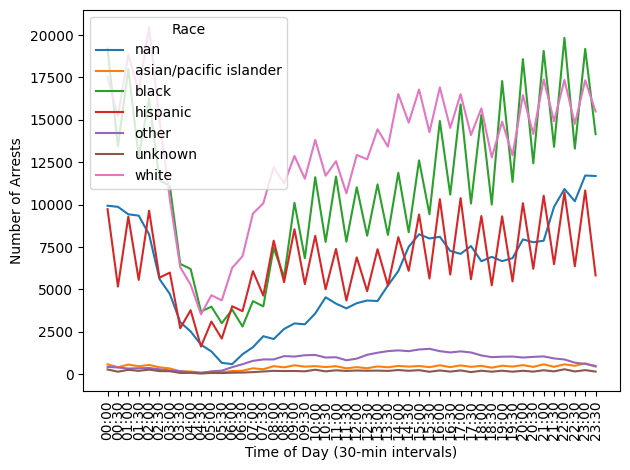

In [33]:
# pivot into wide format
df = arrest_time_race.to_pandas()
df_pivot = df.pivot(index="time", columns="subject_race", values="count")

plt.figure()
for race in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[race], label=race)

plt.xlabel("Time of Day (30‑min intervals)")
plt.ylabel("Number of Arrests")
plt.xticks(rotation=90)
plt.legend(title="Race", loc="best")
plt.tight_layout()
plt.show()

In [34]:
mins_bin = (
    pl.col("time").str.slice(0,2).cast(pl.UInt16)*60
    + pl.col("time").str.slice(3,2).cast(pl.UInt16)
) // 30 * 30

time_bin = (
    (mins_bin // 60).cast(str).str.zfill(2)
    + ":"
    + (mins_bin % 60).cast(str).str.zfill(2)
).alias("time")

reason_time_race = (
    pl.scan_parquet(file_path)
      .select(["time","subject_race","reason_for_stop","arrest_made"])
      .filter(
         pl.col("arrest_made").str.to_lowercase() == "true",
         pl.col("time").str.contains(r"^\d{2}:\d{2}:\d{2}$")
      )
      .group_by([time_bin, "subject_race", "reason_for_stop"])
      .agg(pl.len().alias("count"))
      .sort(["time","subject_race","count"], descending=[False,False,True])
      .collect()
)

print(reason_time_race)

shape: (21_591, 4)
┌───────┬────────────────────────┬─────────────────────────────────┬───────┐
│ time  ┆ subject_race           ┆ reason_for_stop                 ┆ count │
│ ---   ┆ ---                    ┆ ---                             ┆ ---   │
│ str   ┆ str                    ┆ str                             ┆ u32   │
╞═══════╪════════════════════════╪═════════════════════════════════╪═══════╡
│ 00:00 ┆ null                   ┆ null                            ┆ 9921  │
│ 00:00 ┆ null                   ┆ TRAFFIC VIOLATION               ┆ 13    │
│ 00:00 ┆ null                   ┆ CALL FOR SERVICE                ┆ 1     │
│ 00:00 ┆ null                   ┆ SUSPECT PERSON                  ┆ 1     │
│ 00:00 ┆ null                   ┆ M = Moving violation            ┆ 1     │
│ 00:00 ┆ null                   ┆ moving traffic violation        ┆ 1     │
│ 00:00 ┆ asian/pacific islander ┆ null                            ┆ 312   │
│ 00:00 ┆ asian/pacific islander ┆ Driving While Impaired

In [35]:
top_reasons = (
  reason_time_race
    .group_by("reason_for_stop")
    .agg(pl.sum("count").alias("total"))
    .sort("total", descending=True)
    .head(10)
    .select("reason_for_stop")
    .to_series()
    .to_list()
)

filtered = reason_time_race.filter(
  pl.col("reason_for_stop").is_in(top_reasons)
)

print(top_reasons)
print(filtered)

[None, 'Driving While Impaired', 'Vehicle Regulatory Violation', 'Investigation', 'Speed Limit Violation', 'Vehicle Equipment Violation', 'Safe Movement Violation', 'TRAFFIC VIOLATION', 'Other Motor Vehicle Violation', 'Moving violation']
shape: (2_434, 4)
┌───────┬────────────────────────┬───────────────────────────────┬───────┐
│ time  ┆ subject_race           ┆ reason_for_stop               ┆ count │
│ ---   ┆ ---                    ┆ ---                           ┆ ---   │
│ str   ┆ str                    ┆ str                           ┆ u32   │
╞═══════╪════════════════════════╪═══════════════════════════════╪═══════╡
│ 00:00 ┆ null                   ┆ TRAFFIC VIOLATION             ┆ 13    │
│ 00:00 ┆ asian/pacific islander ┆ Driving While Impaired        ┆ 38    │
│ 00:00 ┆ asian/pacific islander ┆ Speed Limit Violation         ┆ 32    │
│ 00:00 ┆ asian/pacific islander ┆ Vehicle Regulatory Violation  ┆ 15    │
│ 00:00 ┆ asian/pacific islander ┆ Vehicle Equipment Violation   ┆ 1

In [ ]:
def compute_or(pdf: pd.DataFrame, title: str):
  pdf = pdf.copy()
  pdf["arrest_made"] = pdf["arrest_made"].astype(int)

  X = pdf.drop(columns=["arrest_made", "mins"])
  y = pdf["arrest_made"]
  strat = pdf["subject_race"]

  Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.3, stratify=strat, random_state=42
  )

  ct = ColumnTransformer([
    ("race",
     OneHotEncoder(handle_unknown="ignore", drop=["white"], sparse_output=True),
     ["subject_race"]),
    ("others",
     OneHotEncoder(handle_unknown="ignore", sparse_output=True),
     ["time", "reason_for_stop", "department_name", "subject_age", "subject_sex"])
  ], remainder="drop")

  pipe = Pipeline([("ct", ct), ("clf", LogisticRegression(max_iter=1000))])
  pipe.fit(Xtr, ytr)

  feat_names = pipe.named_steps["ct"].get_feature_names_out()
  black_feat = next(f for f in feat_names if f.endswith("subject_race_black"))
  idx = list(feat_names).index(black_feat)
  oratio = np.exp(pipe.named_steps["clf"].coef_[0][idx])
  auc = roc_auc_score(yte, pipe.predict_proba(Xte)[:, 1])

  print(f"{title}: OR(Black vs White) = {oratio:.2f}, AUC = {auc:.3f}")


def main():
  SAMPLE_SIZE = 10_000_000


  # 1) Lazy‐load, filter, compute mins, and take a single 10 M‐row sample
  base = (
    pl.scan_parquet(file_path)
    .select([
      "arrest_made", "time", "reason_for_stop",
      "department_name", "subject_race",
      "subject_age", "subject_sex"
    ])
    .filter(
      pl.col("time").str.contains(r"^\d{2}:\d{2}:\d{2}$"),
      pl.col("subject_race").is_not_null(),
      pl.col("arrest_made").is_not_null()
    )
    .with_columns(
      (pl.col("time")
       .str.strptime(pl.Time, "%H:%M:%S")
       .dt.hour() * 60
       + pl.col("time").str.slice(3, 2).cast(pl.UInt32)
       ).alias("mins")
    )
    .limit(SAMPLE_SIZE)
    .collect()
  )

  # 2) Binarize arrest_made
  sample = base.with_columns(
    (pl.col("arrest_made").str.to_lowercase() == "true").alias("arrest_made")
  )

  # 3) Optional: print race distribution
  print("▶ Race counts in 10 M sample:")
  print(
    sample
    .group_by("subject_race")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
  )

  # 4) Convert to pandas and run the model once
  compute_or(sample.to_pandas(), "All times")



# --- compute_or function (required for modeling) ---
def compute_or(pdf: pd.DataFrame, title: str):

  pdf = pdf.copy()
  # Ensure arrest_made is integer (0 or 1)
  pdf["arrest_made"] = pdf["arrest_made"].astype(int)

  # Define features (X) and target (y)
  # Drop 'mins' as 'time' (categorical representation of time) is used
  X = pdf.drop(columns=["arrest_made", "mins"])
  y = pdf["arrest_made"]

  # Use subject_race for stratified splitting
  # Check if multiple race categories exist for stratification
  if pdf["subject_race"].nunique() > 1:
      strat = pdf["subject_race"]
      print(f"Stratifying by subject_race for '{title}'.")
  else:
      strat = None # Cannot stratify if only one category exists
      print(f"Warning: Only one race category found in sample for '{title}'. Cannot stratify split.")


  # Split data into training and testing sets (70% train, 30% test)
  Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.3, stratify=strat, random_state=42 # Use stratify if possible
  )

  # Create a ColumnTransformer for preprocessing
  # OneHotEncode categorical features, using 'white' as reference for race
  ct = ColumnTransformer([
    ("race",
     OneHotEncoder(handle_unknown="ignore", drop=["white"], sparse_output=True),
     ["subject_race"]),
    ("others",
     OneHotEncoder(handle_unknown="ignore", sparse_output=True),
     # Treat time and age as categorical for this model
     ["time", "reason_for_stop", "department_name", "subject_age", "subject_sex"])
  ], remainder="drop", verbose_feature_names_out=False) # Keep feature names cleaner

  # Create a pipeline: Preprocessing -> Logistic Regression
  pipe = Pipeline([("ct", ct), ("clf", LogisticRegression(max_iter=1000))])

  # Train the model
  print(f"Fitting model for '{title}'...")
  pipe.fit(Xtr, ytr)
  print("Fitting complete.")

  # Calculate Odds Ratio for Black vs White
  feat_names = pipe.named_steps["ct"].get_feature_names_out()
  # Manually construct the expected feature name after OHE
  black_feat_name = "subject_race_black"

  try:
    # Find the index of the feature corresponding to 'black' race
    idx = list(feat_names).index(black_feat_name)
    # Get the coefficient and calculate Odds Ratio
    oratio = np.exp(pipe.named_steps["clf"].coef_[0][idx])
    print(f"Coefficient for {black_feat_name}: {pipe.named_steps['clf'].coef_[0][idx]:.4f}")

  except ValueError:
     # Handle cases where 'black' might not be present after splitting or filtering
    print(f"Warning: Feature '{black_feat_name}' not found in model features for '{title}'. Odds Ratio cannot be calculated.")
    print("Available features:", feat_names)
    oratio = np.nan # Assign NaN if feature not found

  # Evaluate the model using AUC on the test set
  print(f"Calculating AUC for '{title}'...")
  auc = roc_auc_score(yte, pipe.predict_proba(Xte)[:, 1])
  print("AUC calculation complete.")

  # Print the results
  print(f"\n>>> RESULT for {title}: OR(Black vs White) = {oratio:.2f}, AUC = {auc:.3f}\n")


def again():
  # Define sample size for the night-time analysis
  # Using 10M based on the last successful detailed run provided
  NIGHT_SAMPLE_SIZE = 10_000_000
  file_path = "openpolicing.parquet" # Make sure this file exists

  # --- Define Time Ranges in Minutes ---
  night_start_min = 17 * 60  # 5 PM = 1020
  night_end_min = 3 * 60    # 3 AM = 180

  print(f"Processing data from: {file_path}")
  print(f"Target sample size for Night/Evening: {NIGHT_SAMPLE_SIZE:,}")
  print(f"Night/Evening period: >= {night_start_min} mins OR < {night_end_min} mins")

  # --- Collect, Process, and Model Night Sample ONLY ---
  print("\nCollecting Night/Evening sample...")
  try:
      # Use the robust approach: filter fully, then limit
      base_lazy_night = (
          pl.scan_parquet(file_path)
          .select([
              "arrest_made", "time", "reason_for_stop",
              "department_name", "subject_race",
              "subject_age", "subject_sex"
          ])
          # Apply all necessary filters first - ensures data quality for model
          .filter(
              pl.col("time").str.contains(r"^\d{2}:\d{2}:\d{2}$"),
              pl.col("arrest_made").is_not_null(), # Target must be non-null
              pl.col("reason_for_stop").is_not_null(),
              pl.col("department_name").is_not_null(),
              pl.col("subject_race").is_not_null(),
              pl.col("subject_age").is_not_null(),
              pl.col("subject_sex").is_not_null()
          )
          # Calculate 'mins' using reliable string slicing
          .with_columns(
              (pl.col("time").str.slice(0, 2).cast(pl.UInt32, strict=False) * 60
               + pl.col("time").str.slice(3, 2).cast(pl.UInt32, strict=False)
               ).alias("mins")
          )
          # Ensure 'mins' calculation was successful (not null from cast errors)
          .filter(pl.col("mins").is_not_null())
          # Apply the time filter for night/evening (5 PM to 3 AM)
          .filter(
              (pl.col("mins") >= night_start_min) | (pl.col("mins") < night_end_min)
          )
          # Limit *after* all filtering
          .limit(NIGHT_SAMPLE_SIZE)
      )
      # Execute the query and collect data into memory
      night_collected = base_lazy_night.collect()

      # Process and Model Night Sample
      if night_collected.height > 0:
          print(f"\n--- Processing Night/Evening Sample (5 PM - 3 AM) ---")
          print(f"Actual sample size: {night_collected.height:,}")
          # Binarize arrest_made (True/False)
          night_sample = night_collected.with_columns(
              (pl.col("arrest_made").str.to_lowercase() == "true").alias("arrest_made")
          )
          # Optional: Print race distribution in the sample
          print("▶ Race counts in Night/Evening sample:")
          print(
              night_sample
              .group_by("subject_race")
              .agg(pl.len().alias("count"))
              .sort("count", descending=True)
          )
          # Convert to Pandas and run the modeling function
          compute_or(night_sample.to_pandas(), "Night/Evening (5 PM - 3 AM)")
      else:
          # This shouldn't happen based on previous runs, but included for safety
          print("\n--- No data found or collected for Night/Evening sample after filtering ---")
          print("    (Check filters and data completeness for this time period if unexpected)")

  except Exception as e:
      print(f"\nAn error occurred during the Night/Evening analysis: {e}")
      # Optional: uncomment below for detailed error traceback
      # import traceback
      # print(traceback.format_exc())


if __name__ == "__main__":
  main()
  again()

▶ Race counts in 10 M sample:
shape: (6, 2)
┌────────────────────────┬─────────┐
│ subject_race           ┆ count   │
│ ---                    ┆ ---     │
│ str                    ┆ u32     │
╞════════════════════════╪═════════╡
│ white                  ┆ 6871177 │
│ black                  ┆ 1452566 │
│ hispanic               ┆ 1222112 │
│ other                  ┆ 202047  │
│ asian/pacific islander ┆ 199079  │
│ unknown                ┆ 53019   │
└────────────────────────┴─────────┘
Stratifying by subject_race for 'All times'.
Fitting model for 'All times'...
Fitting complete.
Coefficient for subject_race_black: 0.2695
Calculating AUC for 'All times'...
